<a href="https://colab.research.google.com/github/dealtron/Hate-Speech-Detection/blob/master/IDHSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Data Science Course - Telkom Digital Talent Incubator*


---




# **Text Mining**

Disini saya melakukan text mining menggunakan data IDHSD_RIO_unbalanced_713_2017.txt (https://github.com/ialfina/id-hatespeech-detection) dan telah saya ubah menjadi csv. Di dalam data ini terdapat 2 atribute, yaitu :

1.   Label (HS, Non_HS),
2.   Tweet.

Disini saya akan mencoba untuk mengklasifikasi tweet dari user dan dan kemudian melakukan prediksi terhadap Tweet tersebut, apakah itu HS (Hate Speech) atau Non_HS (Non Hate Speech)

#### ***Import Libraries***

Disini saya akan menginstall dan mengimport libraries yang akan digunakan pada assignment text mining.

In [1]:
!pip install nltk
!pip install Sastrawi

     |████████████████████████████████| 215kB 6.1MB/s 


In [2]:
# Import Library
import pandas as pd
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import string 
import re
import nltk
from google.colab import files

nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize 
from nltk.probability import FreqDist
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### ***Assigning Data Frame***

Lalu saya akan mengassign dan melihat data apa saja yang saya pakai untuk assignment text mining kali ini

In [14]:
# Import Data to Google Colab
df_bank = pd.read_csv('https://raw.githubusercontent.com/dealtron/Hate-Speech-Detection/master/data/IDHSD.csv', encoding='latin1')
df_bank

,Label,Tweet
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...
...,...,...
708,HS,Muka Si BABi Ahok Tuh Yg Mirip SERBET Lantai.....
709,HS,"Betul bang hancurkan merka bang, musnahkan chi..."
710,HS,"Sapa Yg bilang Ahok anti korupsi!?, klo grombo..."
711,HS,"Gw juga ngimpi SENTILIN BIJI BABI AHOK, pcetar..."


Kemudian disini saya akan menukar posisi column label dan tweet saya

In [15]:
df_bank = df_bank[['Tweet','Label']]

Lalu kemudian disini saya akan mereplace atribute label dari :

*   HS => 1
*   Non_HS => 0



In [16]:
df_bank.Label.replace(('Non_HS', 'HS'), (0, 1), inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4581: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


Disini kita akan melihat seperti apa dataframe yang telah kita olah tadi

In [17]:
df_bank

,Tweet,Label
0,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,0
1,RT @baguscondromowo: Mereka terus melukai aksi...,0
2,Sylvi: bagaimana gurbernur melakukan kekerasan...,0
3,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...",0
4,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,0
...,...,...
708,Muka Si BABi Ahok Tuh Yg Mirip SERBET Lantai.....,1
709,"Betul bang hancurkan merka bang, musnahkan chi...",1
710,"Sapa Yg bilang Ahok anti korupsi!?, klo grombo...",1
711,"Gw juga ngimpi SENTILIN BIJI BABI AHOK, pcetar...",1


#### ***Data Visualization***

Disini kita akan melihat besarnya perbandingan data atribute label

0    453
1    260
Name: Label, dtype: int64


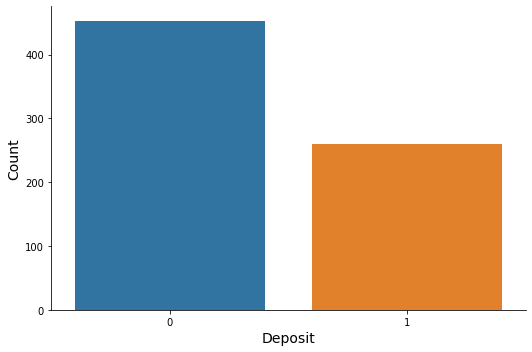

In [18]:
c_depo = df_bank['Label'].value_counts()
print(c_depo)
sns.catplot(x='Label',kind="count", data=df_bank, height=5, aspect=1.5)
plt.xlabel("Deposit", size=14)
plt.ylabel("Count", size=14)
plt.tight_layout()

Dari data yang ada, terdapat :


*   453 data dengan label 0 (Non_HS),
*   260 data dengan label 1 (HS).



Dan kemudian kita lihat info dari dataset yang kita pakai

In [21]:
# Prints the Dataset Information
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   713 non-null    object
 1   Label   713 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.3+ KB


#### ***Data Cleansing***

Disini kita ingin melihat apakah ada data yang kosong/null pada tiap data atribute di dataset yang akan saya gunakan.

In [22]:
# Check for Missing Values
df_bank.isnull().sum()

Tweet    0
Label    0
dtype: int64

Setelah dicek, tidak ada data yang kosong/null di dataset, oleh karena itu tidak perlu digunakan penggantian/penambahan data pada dataset.

#### ***Text Cleaning***

**Lowercase**

Langkah pertama yang saya lakukan disini adalah merubah tiap kata di Tweet menjadi menggunakan lower case

In [23]:
df_bank['Tweet_Lower'] = df_bank['Tweet'].str.lower()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [24]:
df_bank

,Tweet,Label,Tweet_Lower
0,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,0,rt @spardaxyz: fadli zon minta mendagri segera...
1,RT @baguscondromowo: Mereka terus melukai aksi...,0,rt @baguscondromowo: mereka terus melukai aksi...
2,Sylvi: bagaimana gurbernur melakukan kekerasan...,0,sylvi: bagaimana gurbernur melakukan kekerasan...
3,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...",0,"ahmad dhani tak puas debat pilkada, masalah ja..."
4,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,0,rt @lisdaulay28: waspada ktp palsu.....kawal p...
...,...,...,...
708,Muka Si BABi Ahok Tuh Yg Mirip SERBET Lantai.....,1,muka si babi ahok tuh yg mirip serbet lantai.....
709,"Betul bang hancurkan merka bang, musnahkan chi...",1,"betul bang hancurkan merka bang, musnahkan chi..."
710,"Sapa Yg bilang Ahok anti korupsi!?, klo grombo...",1,"sapa yg bilang ahok anti korupsi!?, klo grombo..."
711,"Gw juga ngimpi SENTILIN BIJI BABI AHOK, pcetar...",1,"gw juga ngimpi sentilin biji babi ahok, pcetar..."


**Tokenization**

Lalu disini saya akan menghilangkan url, hashtag, mention, link, emoticon, tab, angka, tanda baca, single character (satu huruf saja), spasi, dll.

In [25]:
def remove_tweet_special(text):
    # remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # remove non ASCII (emoticon, chinese word, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # remove incomplete URL
    return text.replace("http://", " ").replace("https://", " ")
                
df_bank['Tweet_Rem'] = df_bank['Tweet_Lower'].apply(remove_tweet_special)

#remove number
def remove_number(text):
    return  re.sub(r"\d+", "", text)

df_bank['Tweet_Rem'] = df_bank['Tweet_Rem'].apply(remove_number)

#remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

df_bank['Tweet_Rem'] = df_bank['Tweet_Rem'].apply(remove_punctuation)

#remove whitespace leading & trailing
def remove_whitespace_LT(text):
    return text.strip()

df_bank['Tweet_Rem'] = df_bank['Tweet_Rem'].apply(remove_whitespace_LT)

#remove multiple whitespace into single whitespace
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

df_bank['Tweet_Rem'] = df_bank['Tweet_Rem'].apply(remove_whitespace_multiple)

# remove single char
def remove_singl_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

df_bank['Tweet_Rem'] = df_bank['Tweet_Rem'].apply(remove_singl_char)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

Dan kemudian saya akan melakukan tokenization

In [26]:
# NLTK word rokenize 
def word_tokenize_wrapper(text):
    return word_tokenize(text)

df_bank['Tweet_Token'] = df_bank['Tweet_Rem'].apply(word_tokenize_wrapper)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [27]:
df_bank

,Tweet,Label,Tweet_Lower,Tweet_Rem,Tweet_Token
0,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,0,rt @spardaxyz: fadli zon minta mendagri segera...,rt fadli zon minta mendagri segera menonaktifk...,"[rt, fadli, zon, minta, mendagri, segera, meno..."
1,RT @baguscondromowo: Mereka terus melukai aksi...,0,rt @baguscondromowo: mereka terus melukai aksi...,rt mereka terus melukai aksi dalam rangka meme...,"[rt, mereka, terus, melukai, aksi, dalam, rang..."
2,Sylvi: bagaimana gurbernur melakukan kekerasan...,0,sylvi: bagaimana gurbernur melakukan kekerasan...,sylvi bagaimana gurbernur melakukan kekerasan ...,"[sylvi, bagaimana, gurbernur, melakukan, keker..."
3,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...",0,"ahmad dhani tak puas debat pilkada, masalah ja...",ahmad dhani tak puas debat pilkada masalah jal...,"[ahmad, dhani, tak, puas, debat, pilkada, masa..."
4,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,0,rt @lisdaulay28: waspada ktp palsu.....kawal p...,rt waspada ktp palsukawal pilkada,"[rt, waspada, ktp, palsukawal, pilkada]"
...,...,...,...,...,...
708,Muka Si BABi Ahok Tuh Yg Mirip SERBET Lantai.....,1,muka si babi ahok tuh yg mirip serbet lantai.....,muka si babi ahok tuh yg mirip serbet lantai btp,"[muka, si, babi, ahok, tuh, yg, mirip, serbet,..."
709,"Betul bang hancurkan merka bang, musnahkan chi...",1,"betul bang hancurkan merka bang, musnahkan chi...",betul bang hancurkan merka bang musnahkan chin...,"[betul, bang, hancurkan, merka, bang, musnahka..."
710,"Sapa Yg bilang Ahok anti korupsi!?, klo grombo...",1,"sapa yg bilang ahok anti korupsi!?, klo grombo...",sapa yg bilang ahok anti korupsi klo grombolan...,"[sapa, yg, bilang, ahok, anti, korupsi, klo, g..."
711,"Gw juga ngimpi SENTILIN BIJI BABI AHOK, pcetar...",1,"gw juga ngimpi sentilin biji babi ahok, pcetar...",gw juga ngimpi sentilin biji babi ahok pcetar ...,"[gw, juga, ngimpi, sentilin, biji, babi, ahok,..."


In [ ]:
df_bank.to_csv('filename.csv') 
files.download('filename.csv')

**Stopwords**

Disini saya akan melakukan text cleansing stopwords bahasa indonesia dari stopwords yang ada dan juga yang telah saya tambahkan secara manual

In [28]:
list_stopwords = stopwords.words('indonesian')

list_stopwords.extend(["yg", "dg", "rt", "dgn", "ny", "d", 'klo', 
                       'kalo', 'amp', 'biar', 'bikin', 'bilang', 
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih', 
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya', 
                       'jd', 'jgn', 'sdh', 'aja', 'n', 't', 
                       'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
                       '&amp', 'yah'])

list_stopwords = set(list_stopwords)

def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

df_bank['Tweet_Token_Stopwords'] = df_bank['Tweet_Token'].apply(stopwords_removal)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [29]:
df_bank

,Tweet,Label,Tweet_Lower,Tweet_Rem,Tweet_Token,Tweet_Token_Stopwords
0,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,0,rt @spardaxyz: fadli zon minta mendagri segera...,rt fadli zon minta mendagri segera menonaktifk...,"[rt, fadli, zon, minta, mendagri, segera, meno...","[fadli, zon, mendagri, menonaktifkan, ahok, gu..."
1,RT @baguscondromowo: Mereka terus melukai aksi...,0,rt @baguscondromowo: mereka terus melukai aksi...,rt mereka terus melukai aksi dalam rangka meme...,"[rt, mereka, terus, melukai, aksi, dalam, rang...","[melukai, aksi, rangka, memenjarakan, ahok, ah..."
2,Sylvi: bagaimana gurbernur melakukan kekerasan...,0,sylvi: bagaimana gurbernur melakukan kekerasan...,sylvi bagaimana gurbernur melakukan kekerasan ...,"[sylvi, bagaimana, gurbernur, melakukan, keker...","[sylvi, gurbernur, kekerasan, perempuan, bukti..."
3,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...",0,"ahmad dhani tak puas debat pilkada, masalah ja...",ahmad dhani tak puas debat pilkada masalah jal...,"[ahmad, dhani, tak, puas, debat, pilkada, masa...","[ahmad, dhani, puas, debat, pilkada, jalan, be..."
4,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,0,rt @lisdaulay28: waspada ktp palsu.....kawal p...,rt waspada ktp palsukawal pilkada,"[rt, waspada, ktp, palsukawal, pilkada]","[waspada, ktp, palsukawal, pilkada]"
...,...,...,...,...,...,...
708,Muka Si BABi Ahok Tuh Yg Mirip SERBET Lantai.....,1,muka si babi ahok tuh yg mirip serbet lantai.....,muka si babi ahok tuh yg mirip serbet lantai btp,"[muka, si, babi, ahok, tuh, yg, mirip, serbet,...","[muka, babi, ahok, serbet, lantai, btp]"
709,"Betul bang hancurkan merka bang, musnahkan chi...",1,"betul bang hancurkan merka bang, musnahkan chi...",betul bang hancurkan merka bang musnahkan chin...,"[betul, bang, hancurkan, merka, bang, musnahka...","[bang, hancurkan, merka, bang, musnahkan, chin..."
710,"Sapa Yg bilang Ahok anti korupsi!?, klo grombo...",1,"sapa yg bilang ahok anti korupsi!?, klo grombo...",sapa yg bilang ahok anti korupsi klo grombolan...,"[sapa, yg, bilang, ahok, anti, korupsi, klo, g...","[sapa, ahok, anti, korupsi, grombolannya, ngom..."
711,"Gw juga ngimpi SENTILIN BIJI BABI AHOK, pcetar...",1,"gw juga ngimpi sentilin biji babi ahok, pcetar...",gw juga ngimpi sentilin biji babi ahok pcetar ...,"[gw, juga, ngimpi, sentilin, biji, babi, ahok,...","[gw, ngimpi, sentilin, biji, babi, ahok, pceta..."


**Stemming**

Disini saya akan melakukan stemming bahasa indonesia

In [30]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
df_bank['Tweet_Token_Stem'] = df_bank['Tweet_Token_Stopwords'].apply(lambda x: [stemmer.stem(y) for y in x])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
df_bank

,Tweet,Label,Tweet_Lower,Tweet_Rem,Tweet_Token,Tweet_Token_Stopwords,Tweet_Token_Stem
0,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,0,rt @spardaxyz: fadli zon minta mendagri segera...,rt fadli zon minta mendagri segera menonaktifk...,"[rt, fadli, zon, minta, mendagri, segera, meno...","[fadli, zon, mendagri, menonaktifkan, ahok, gu...","[fadli, zon, mendagri, nonaktif, ahok, gubernu..."
1,RT @baguscondromowo: Mereka terus melukai aksi...,0,rt @baguscondromowo: mereka terus melukai aksi...,rt mereka terus melukai aksi dalam rangka meme...,"[rt, mereka, terus, melukai, aksi, dalam, rang...","[melukai, aksi, rangka, memenjarakan, ahok, ah...","[luka, aksi, rangka, penjara, ahok, ahok, gaga..."
2,Sylvi: bagaimana gurbernur melakukan kekerasan...,0,sylvi: bagaimana gurbernur melakukan kekerasan...,sylvi bagaimana gurbernur melakukan kekerasan ...,"[sylvi, bagaimana, gurbernur, melakukan, keker...","[sylvi, gurbernur, kekerasan, perempuan, bukti...","[sylvi, gurbernur, keras, perempuan, bukti, fo..."
3,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...",0,"ahmad dhani tak puas debat pilkada, masalah ja...",ahmad dhani tak puas debat pilkada masalah jal...,"[ahmad, dhani, tak, puas, debat, pilkada, masa...","[ahmad, dhani, puas, debat, pilkada, jalan, be...","[ahmad, dhani, puas, debat, pilkada, jalan, be..."
4,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,0,rt @lisdaulay28: waspada ktp palsu.....kawal p...,rt waspada ktp palsukawal pilkada,"[rt, waspada, ktp, palsukawal, pilkada]","[waspada, ktp, palsukawal, pilkada]","[waspada, ktp, palsukawal, pilkada]"
...,...,...,...,...,...,...,...
708,Muka Si BABi Ahok Tuh Yg Mirip SERBET Lantai.....,1,muka si babi ahok tuh yg mirip serbet lantai.....,muka si babi ahok tuh yg mirip serbet lantai btp,"[muka, si, babi, ahok, tuh, yg, mirip, serbet,...","[muka, babi, ahok, serbet, lantai, btp]","[muka, babi, ahok, serbet, lantai, btp]"
709,"Betul bang hancurkan merka bang, musnahkan chi...",1,"betul bang hancurkan merka bang, musnahkan chi...",betul bang hancurkan merka bang musnahkan chin...,"[betul, bang, hancurkan, merka, bang, musnahka...","[bang, hancurkan, merka, bang, musnahkan, chin...","[bang, hancur, merka, bang, musnah, china, bab..."
710,"Sapa Yg bilang Ahok anti korupsi!?, klo grombo...",1,"sapa yg bilang ahok anti korupsi!?, klo grombo...",sapa yg bilang ahok anti korupsi klo grombolan...,"[sapa, yg, bilang, ahok, anti, korupsi, klo, g...","[sapa, ahok, anti, korupsi, grombolannya, ngom...","[sapa, ahok, anti, korupsi, grombolannya, ngom..."
711,"Gw juga ngimpi SENTILIN BIJI BABI AHOK, pcetar...",1,"gw juga ngimpi sentilin biji babi ahok, pcetar...",gw juga ngimpi sentilin biji babi ahok pcetar ...,"[gw, juga, ngimpi, sentilin, biji, babi, ahok,...","[gw, ngimpi, sentilin, biji, babi, ahok, pceta...","[gw, ngimpi, sentilin, biji, babi, ahok, pceta..."


**To String and Sorted**

In [33]:
df_bank['Tweet_String'] = df_bank['Tweet_Token_Stem'].apply(' '.join)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
df_bank = df_bank[['Tweet','Tweet_Lower','Tweet_Rem','Tweet_Token','Tweet_Token_Stopwords','Tweet_Token_Stem','Tweet_String','Label']]

In [36]:
df_bank

,Tweet,Tweet_Lower,Tweet_Rem,Tweet_Token,Tweet_Token_Stopwords,Tweet_Token_Stem,Tweet_String,Label
0,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,rt @spardaxyz: fadli zon minta mendagri segera...,rt fadli zon minta mendagri segera menonaktifk...,"[rt, fadli, zon, minta, mendagri, segera, meno...","[fadli, zon, mendagri, menonaktifkan, ahok, gu...","[fadli, zon, mendagri, nonaktif, ahok, gubernu...",fadli zon mendagri nonaktif ahok gubernur dki,0
1,RT @baguscondromowo: Mereka terus melukai aksi...,rt @baguscondromowo: mereka terus melukai aksi...,rt mereka terus melukai aksi dalam rangka meme...,"[rt, mereka, terus, melukai, aksi, dalam, rang...","[melukai, aksi, rangka, memenjarakan, ahok, ah...","[luka, aksi, rangka, penjara, ahok, ahok, gaga...",luka aksi rangka penjara ahok ahok gagal pilkada,0
2,Sylvi: bagaimana gurbernur melakukan kekerasan...,sylvi: bagaimana gurbernur melakukan kekerasan...,sylvi bagaimana gurbernur melakukan kekerasan ...,"[sylvi, bagaimana, gurbernur, melakukan, keker...","[sylvi, gurbernur, kekerasan, perempuan, bukti...","[sylvi, gurbernur, keras, perempuan, bukti, fo...",sylvi gurbernur keras perempuan bukti foto bareng,0
3,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...","ahmad dhani tak puas debat pilkada, masalah ja...",ahmad dhani tak puas debat pilkada masalah jal...,"[ahmad, dhani, tak, puas, debat, pilkada, masa...","[ahmad, dhani, puas, debat, pilkada, jalan, be...","[ahmad, dhani, puas, debat, pilkada, jalan, be...",ahmad dhani puas debat pilkada jalan bekas ungkap,0
4,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,rt @lisdaulay28: waspada ktp palsu.....kawal p...,rt waspada ktp palsukawal pilkada,"[rt, waspada, ktp, palsukawal, pilkada]","[waspada, ktp, palsukawal, pilkada]","[waspada, ktp, palsukawal, pilkada]",waspada ktp palsukawal pilkada,0
...,...,...,...,...,...,...,...,...
708,Muka Si BABi Ahok Tuh Yg Mirip SERBET Lantai.....,muka si babi ahok tuh yg mirip serbet lantai.....,muka si babi ahok tuh yg mirip serbet lantai btp,"[muka, si, babi, ahok, tuh, yg, mirip, serbet,...","[muka, babi, ahok, serbet, lantai, btp]","[muka, babi, ahok, serbet, lantai, btp]",muka babi ahok serbet lantai btp,1
709,"Betul bang hancurkan merka bang, musnahkan chi...","betul bang hancurkan merka bang, musnahkan chi...",betul bang hancurkan merka bang musnahkan chin...,"[betul, bang, hancurkan, merka, bang, musnahka...","[bang, hancurkan, merka, bang, musnahkan, chin...","[bang, hancur, merka, bang, musnah, china, bab...",bang hancur merka bang musnah china babi bumi ...,1
710,"Sapa Yg bilang Ahok anti korupsi!?, klo grombo...","sapa yg bilang ahok anti korupsi!?, klo grombo...",sapa yg bilang ahok anti korupsi klo grombolan...,"[sapa, yg, bilang, ahok, anti, korupsi, klo, g...","[sapa, ahok, anti, korupsi, grombolannya, ngom...","[sapa, ahok, anti, korupsi, grombolannya, ngom...",sapa ahok anti korupsi grombolannya ngomong gt...,1
711,"Gw juga ngimpi SENTILIN BIJI BABI AHOK, pcetar...","gw juga ngimpi sentilin biji babi ahok, pcetar...",gw juga ngimpi sentilin biji babi ahok pcetar ...,"[gw, juga, ngimpi, sentilin, biji, babi, ahok,...","[gw, ngimpi, sentilin, biji, babi, ahok, pceta...","[gw, ngimpi, sentilin, biji, babi, ahok, pceta...",gw ngimpi sentilin biji babi ahok pcetar pceta...,1


# **Classification**

Untuk classification, saya akan melakukan test split dengan persentase train sebesar 80% dan test sebesar 20%, dan juga disini saya menggunakan stratify, karena data yang ada **unbalanced**

In [58]:
X_train_ori, X_test_ori, y_train, y_test = model_selection.train_test_split(df_bank['Tweet_String'],df_bank['Label'],test_size=0.2,stratify=df_bank['Label'])

Untuk feature extraction yang saat ini saya pakai adalah TF-IDF vectorizer

In [59]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#vectorizer = CountVectorizer()
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train_ori)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [60]:
X_train = vectorizer.transform(X_train_ori).toarray()
X_test = vectorizer.transform(X_test_ori).toarray()

#### ***Gaussian Naive Bayes***

**Modeling Naive Bayes**

In [93]:
# Import Module
from sklearn.naive_bayes import GaussianNB 

# Modeling Naive Bayes Classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Predict to Test Data
y_pred_gnb= gnb.predict(X_test)

**Model Evaluation**

In [94]:
# Show the Confussion Matrix
cm_gnb = metrics.confusion_matrix(y_test, y_pred_gnb)
cm_gnb

array([[59, 32],
       [ 9, 43]])

In [95]:
# Show the Accuracy, Precision, Recall
acc_gnb = metrics.accuracy_score(y_test, y_pred_gnb)
prec_gnb = metrics.precision_score(y_test, y_pred_gnb)
rec_gnb = metrics.recall_score(y_test, y_pred_gnb)
f1_gnb = metrics.f1_score(y_test, y_pred_gnb)
kappa_gnb = metrics.cohen_kappa_score(y_test, y_pred_gnb)

print("Accuracy:", acc_gnb)
print("Precision:", prec_gnb)
print("Recall:", rec_gnb)
print("F1 Score:", f1_gnb)
print("Cohens Kappa Score:", kappa_gnb)

Accuracy: 0.7132867132867133
Precision: 0.5733333333333334
Recall: 0.8269230769230769
F1 Score: 0.6771653543307086
Cohens Kappa Score: 0.43412797992471763


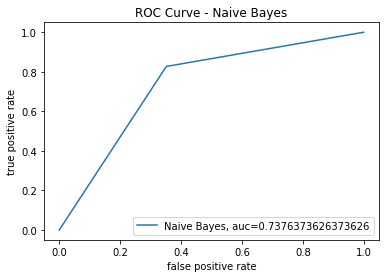

In [96]:
# ROC Curve
y_pred_gnb_proba = gnb.predict_proba(X_test)[::,1]
fprgnb, tprgnb, _ = metrics.roc_curve(y_test,  y_pred_gnb_proba)
aucgnb = metrics.roc_auc_score(y_test, y_pred_gnb_proba)
plt.plot(fprgnb,tprgnb,label="Naive Bayes, auc="+str(aucgnb))
plt.title('ROC Curve - Naive Bayes')
plt.xlabel('false positive rate') 
plt.ylabel('true positive rate')
plt.legend(loc=4)
plt.show()

#### ***Multinomial Naive Bayes***

**Modeling Naive Bayes**

In [97]:
# Import Module
from sklearn.naive_bayes import GaussianNB 

# Modeling Naive Bayes Classifier
mnm = naive_bayes.MultinomialNB()
mnm.fit(X_train, y_train)

# Predict to Test Data
y_pred_mnm= mnm.predict(X_test)

**Model Evaluation**

In [98]:
# Show the Confussion Matrix
cm_mnm = metrics.confusion_matrix(y_test, y_pred_mnm)
cm_mnm

array([[86,  5],
       [17, 35]])

In [99]:
# Show the Accuracy, Precision, Recall
acc_mnm = metrics.accuracy_score(y_test, y_pred_mnm)
prec_mnm = metrics.precision_score(y_test, y_pred_mnm)
rec_mnm = metrics.recall_score(y_test, y_pred_mnm)
f1_mnm = metrics.f1_score(y_test, y_pred_mnm)
kappa_mnm = metrics.cohen_kappa_score(y_test, y_pred_mnm)

print("Accuracy:", acc_mnm)
print("Precision:", prec_mnm)
print("Recall:", rec_mnm)
print("F1 Score:", f1_mnm)
print("Cohens Kappa Score:", kappa_mnm)

Accuracy: 0.8461538461538461
Precision: 0.875
Recall: 0.6730769230769231
F1 Score: 0.7608695652173914
Cohens Kappa Score: 0.6502890173410405


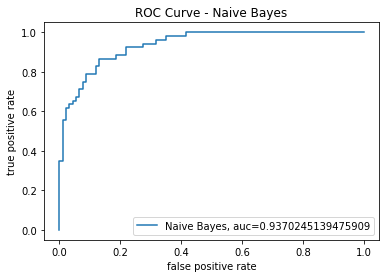

In [100]:
# ROC Curve
y_pred_mnm_proba = mnm.predict_proba(X_test)[::,1]
fprmnm, tprmnm, _ = metrics.roc_curve(y_test,  y_pred_mnm_proba)
aucmnm = metrics.roc_auc_score(y_test, y_pred_mnm_proba)
plt.plot(fprmnm,tprmnm,label="Naive Bayes, auc="+str(aucmnm))
plt.title('ROC Curve - Naive Bayes')
plt.xlabel('false positive rate') 
plt.ylabel('true positive rate')
plt.legend(loc=4)
plt.show()

#### ***K-Nearest Neighbor***

**Modelling K-NN**

In [101]:
# Import Module
from sklearn.neighbors import KNeighborsClassifier

# Modeling KNN
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Predict to Test Data
y_pred_knn= knn.predict(X_test)

**Model Evaluation**

In [102]:
# Show the Confussion Matrix
cm_knn = metrics.confusion_matrix(y_test, y_pred_knn)
cm_knn

array([[82,  9],
       [16, 36]])

In [103]:
# Show the Accuracy, Precision, Recall
acc_knn = metrics.accuracy_score(y_test, y_pred_knn)
prec_knn = metrics.precision_score(y_test, y_pred_knn)
rec_knn = metrics.recall_score(y_test, y_pred_knn)
f1_knn = metrics.f1_score(y_test, y_pred_knn)
kappa_knn = metrics.cohen_kappa_score(y_test, y_pred_knn)

print("Accuracy:", acc_knn)
print("Precision:", prec_knn)
print("Recall:", rec_knn)
print("F1 Score:", f1_knn)
print("Cohens Kappa Score:", kappa_knn)

Accuracy: 0.8251748251748252
Precision: 0.8
Recall: 0.6923076923076923
F1 Score: 0.7422680412371134
Cohens Kappa Score: 0.611032531824611


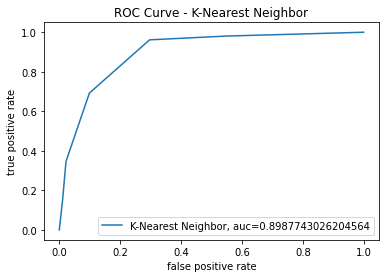

In [104]:
# ROC Curve
y_pred_knn_proba = knn.predict_proba(X_test)[::,1]
fprknn, tprknn, _ = metrics.roc_curve(y_test,  y_pred_knn_proba)
aucknn = metrics.roc_auc_score(y_test, y_pred_knn_proba)
plt.plot(fprknn,tprknn,label="K-Nearest Neighbor, auc="+str(aucknn))
plt.title('ROC Curve - K-Nearest Neighbor')
plt.xlabel('false positive rate') 
plt.ylabel('true positive rate')
plt.legend(loc=4)
plt.show()

#### ***Random Forest***

**Modeling Random Forest**

In [105]:
# Import Module
from sklearn.ensemble import RandomForestClassifier

# Modeling Random Forest
rfo = RandomForestClassifier()
rfo.fit(X_train, y_train)

# Predict to Test Data
y_pred_rfo= rfo.predict(X_test)

**Model Evaluation**

In [106]:
# Show the Confussion Matrix
cm_rfo = metrics.confusion_matrix(y_test, y_pred_rfo)
cm_rfo

array([[84,  7],
       [16, 36]])

In [107]:
# Show the Accuracy, Precision, Recall
acc_rfo = metrics.accuracy_score(y_test, y_pred_rfo)
prec_rfo = metrics.precision_score(y_test, y_pred_rfo)
rec_rfo = metrics.recall_score(y_test, y_pred_rfo)
f1_rfo = metrics.f1_score(y_test, y_pred_rfo)
kappa_rfo = metrics.cohen_kappa_score(y_test, y_pred_rfo)

print("Accuracy:", acc_rfo)
print("Precision:", prec_rfo)
print("Recall:", rec_rfo)
print("F1 Score:", f1_rfo)
print("Cohens Kappa Score:", kappa_rfo)

Accuracy: 0.8391608391608392
Precision: 0.8372093023255814
Recall: 0.6923076923076923
F1 Score: 0.7578947368421053
Cohens Kappa Score: 0.6390870185449358


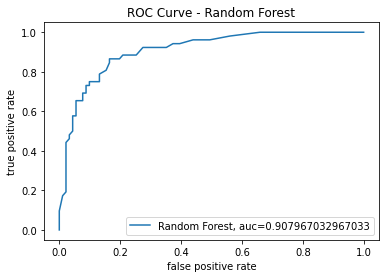

In [108]:
y_pred_rfo_proba = rfo.predict_proba(X_test)[::,1]
fprrfo, tprrfo, _ = metrics.roc_curve(y_test,  y_pred_rfo_proba)
aucrfo = metrics.roc_auc_score(y_test, y_pred_rfo_proba)
plt.plot(fprrfo,tprrfo,label="Random Forest, auc="+str(aucrfo))
plt.title('ROC Curve - Random Forest')
plt.xlabel('false positive rate') 
plt.ylabel('true positive rate')
plt.legend(loc=4)
plt.show()

#### ***SVM***

**Modeling SVM**

In [109]:
# Import Module
from sklearn import svm

# Modeling Random Forest
esvm = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
esvm.fit(X_train, y_train)

# Predict to Test Data
y_pred_esvm= esvm.predict(X_test)

**Model Evaluation**

In [110]:
# Show the Confussion Matrix
cm_esvm = metrics.confusion_matrix(y_test, y_pred_esvm)
cm_esvm

array([[84,  7],
       [16, 36]])

In [111]:
# Show the Accuracy, Precision, Recall
acc_esvm = metrics.accuracy_score(y_test, y_pred_esvm)
prec_esvm = metrics.precision_score(y_test, y_pred_esvm)
rec_esvm = metrics.recall_score(y_test, y_pred_esvm)
f1_esvm = metrics.f1_score(y_test, y_pred_esvm)
kappa_esvm = metrics.cohen_kappa_score(y_test, y_pred_esvm)

print("Accuracy:", acc_esvm)
print("Precision:", prec_esvm)
print("Recall:", rec_esvm)
print("F1 Score:", f1_esvm)
print("Cohens Kappa Score:", kappa_esvm)

Accuracy: 0.8391608391608392
Precision: 0.8372093023255814
Recall: 0.6923076923076923
F1 Score: 0.7578947368421053
Cohens Kappa Score: 0.6390870185449358


#### ***Model Comparison***

In [114]:
# Comparing Model Performance
print("Gaussian Naive Bayes Accuracy = {0:.2f}%".format(acc_gnb*100))
print("Gaussian Naive Bayes Precision = {0:.2f}%".format(prec_gnb*100))
print("Gaussian Naive Bayes Recall = {0:.2f}%".format(rec_gnb*100))
print("Gaussian Naive Bayes F1-Score = {0:.2f}%".format(f1_gnb*100))
print("_______________________")
print("Multinomial Naive Bayes Accuracy = {0:.2f}%".format(acc_mnm*100))
print("Multinomial Naive Bayes Precision = {0:.2f}%".format(prec_mnm*100))
print("Multinomial Naive Bayes Recall = {0:.2f}%".format(rec_mnm*100))
print("Multinomial Naive Bayes F1-Score = {0:.2f}%".format(f1_mnm*100))
print("_______________________")
print("K-Nearest Neighbor Accuracy = {0:.2f}%".format(acc_knn*100))
print("K-Nearest Neighbor Precision = {0:.2f}%".format(prec_knn*100))
print("K-Nearest Neighbor Recall = {0:.2f}%".format(rec_knn*100))
print("K-Nearest Neighbor F1-Score = {0:.2f}%".format(f1_knn*100))
print("_______________________")
print("Random Forest Accuracy = {0:.2f}%".format(acc_rfo*100))
print("Random Forest Precision = {0:.2f}%".format(prec_rfo*100))
print("Random Forest Recall = {0:.2f}%".format(rec_rfo*100))
print("Random Forest F1-Score = {0:.2f}%".format(f1_rfo*100))
print("_______________________")
print("SVM Accuracy = {0:.2f}%".format(acc_esvm*100))
print("SVM Precision = {0:.2f}%".format(prec_esvm*100))
print("SVM Recall = {0:.2f}%".format(rec_esvm*100))
print("SVM F1-Score = {0:.2f}%".format(f1_esvm*100))

Gaussian Naive Bayes Accuracy = 71.33%
Gaussian Naive Bayes Precision = 57.33%
Gaussian Naive Bayes Recall = 82.69%
Gaussian Naive Bayes F1-Score = 67.72%
_______________________
Multinomial Naive Bayes Accuracy = 84.62%
Multinomial Naive Bayes Precision = 87.50%
Multinomial Naive Bayes Recall = 67.31%
Multinomial Naive Bayes F1-Score = 76.09%
_______________________
K-Nearest Neighbor Accuracy = 82.52%
K-Nearest Neighbor Precision = 80.00%
K-Nearest Neighbor Recall = 69.23%
K-Nearest Neighbor F1-Score = 74.23%
_______________________
Random Forest Accuracy = 83.92%
Random Forest Precision = 83.72%
Random Forest Recall = 69.23%
Random Forest F1-Score = 75.79%
_______________________
SVM Accuracy = 83.92%
SVM Precision = 83.72%
SVM Recall = 69.23%
SVM F1-Score = 75.79%


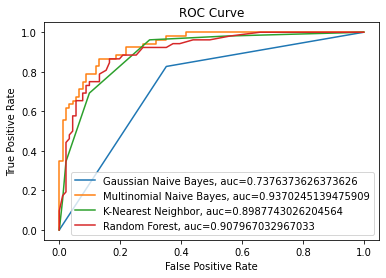

In [113]:
# Comparing ROC Curve
plt.plot(fprgnb,tprgnb,label="Gaussian Naive Bayes, auc="+str(aucgnb))
plt.plot(fprmnm,tprmnm,label="Multinomial Naive Bayes, auc="+str(aucmnm))
plt.plot(fprknn,tprknn,label="K-Nearest Neighbor, auc="+str(aucknn))
plt.plot(fprrfo,tprrfo,label="Random Forest, auc="+str(aucrfo))
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

#### ***Kesimpulan***

Disini kita bisa melihat, dari 5 model klasifikasi yang dilakukan, model klasifikasi text terbaik yang untuk dataset ini pada :

* Accuracy, Multinomial Naive Bayes = 84.62%,
* Precision, Multinomial Naive Bayes = 87.50%,
* Recall, Gaussian Naive Bayes = 82.69%,
* F1-Score, Multinomial Naive Bayes = 76.09%,
* AUC, Multinomial Naive Bayes = 0.937.

Dari sini kita bisa menyimpulkan bahwa **Multinomial Naive Bayes** adalah model klasifikasi text terbaik untuk dataset IDHSD_RIO_unbalanced_713_2017.txt.